In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
from contextily import add_basemap
from rasterio import windows
from scipy.stats import mode
from skimage.exposure import rescale_intensity
from skimage.segmentation import slic

In [2]:
# Data parameter
s1_aceh_before = "https://storage.googleapis.com/gee-ramiqcom-bucket/banjir_indonesia/sentinel-1/aceh_2025-11-21_S1_RTC_composite_2025-11-20_2025-11-22_10m.tif"
s1_aceh_after = "https://storage.googleapis.com/gee-ramiqcom-bucket/banjir_indonesia/sentinel-1/aceh_2025-11-28_S1_RTC_composite_2025-11-27_2025-11-29_10m.tif"
s1_sumatera_utara_before = "https://storage.googleapis.com/gee-ramiqcom-bucket/banjir_indonesia/sentinel-1/sumatera_utara_2025-11-21_S1_RTC_composite_2025-11-20_2025-11-22_10m.tif"
s1_sumatear_utara_after = "https://storage.googleapis.com/gee-ramiqcom-bucket/banjir_indonesia/sentinel-1/sumatera_utara_2025-11-28_S1_RTC_composite_2025-11-27_2025-11-29_10m.tif"
roi = "https://storage.googleapis.com/gee-ramiqcom-bucket/banjir_indonesia/rois/flood_sumatera_roi.geojson"

In [3]:
# Data dictionary
data_dict = [
    dict(
        provinsi="Aceh",
        period=[
            dict(name="Before", date="2025-11-21", s1=s1_aceh_before),
            dict(name="After", date="2025-11-28", s1=s1_aceh_after),
        ],
    ),
    dict(
        provinsi="Sumatera Utara",
        period=[
            dict(name="Before", date="2025-11-21", s1=s1_sumatera_utara_before),
            dict(name="After", date="2025-11-28", s1=s1_sumatear_utara_after),
        ],
    ),
]

,id,name,provinsi,geometry
0,1,Padang Tiji,Aceh,"MULTIPOLYGON (((95.78337 5.24725, 95.78337 5.4..."
1,2,Sigli,Aceh,"MULTIPOLYGON (((95.48551 5.29529, 95.48551 5.4..."
2,3,Lhokseumawe,Aceh,"MULTIPOLYGON (((96.99152 5.08081, 96.99152 5.2..."
3,4,Meulaboh,Aceh,"MULTIPOLYGON (((95.89164 4.0903, 95.89164 4.45..."
4,5,Darul Makmur,Aceh,"MULTIPOLYGON (((96.30719 3.75188, 96.30719 4.1..."
5,6,Aceh Selatan,Aceh,"MULTIPOLYGON (((97.25772 2.98578, 97.25772 3.2..."
6,7,Aceh Singkil,Aceh,"MULTIPOLYGON (((97.74395 2.26921, 97.74395 2.4..."
7,8,Rundeng,Aceh,"MULTIPOLYGON (((97.73094 2.59992, 97.73094 2.8..."
8,9,Pante Beudari,Aceh,"MULTIPOLYGON (((97.32231 4.74472, 97.32231 5.0..."
9,10,Pante Peureulak,Aceh,"MULTIPOLYGON (((97.58087 4.56014, 97.58087 4.8..."


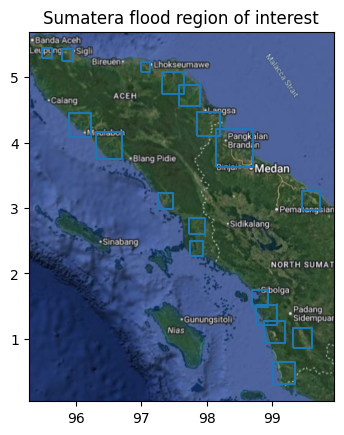

In [5]:
# Plot region of interest
df_roi = gpd.read_file(roi)
ax = df_roi.boundary.plot()
add_basemap(
    ax,
    crs="EPSG:4326",
    source="http://mt0.google.com/vt/lyrs=y&hl=en&x={x}&y={y}&z={z}",
)
ax.set_title("Sumatera flood region of interest")
df_roi

Processing Kuala Simpang


C:\Users\ramiq\AppData\Local\Temp\ipykernel_17744\494762152.py:39: RuntimeWarning: invalid value encountered in divide
  rdi = (vv / 1e4 - vh / 1e4) / (vv / 1e4 + vh / 1e4)
C:\Users\ramiq\AppData\Local\Temp\ipykernel_17744\494762152.py:48: RuntimeWarning: invalid value encountered in cast
  ).astype("uint8")


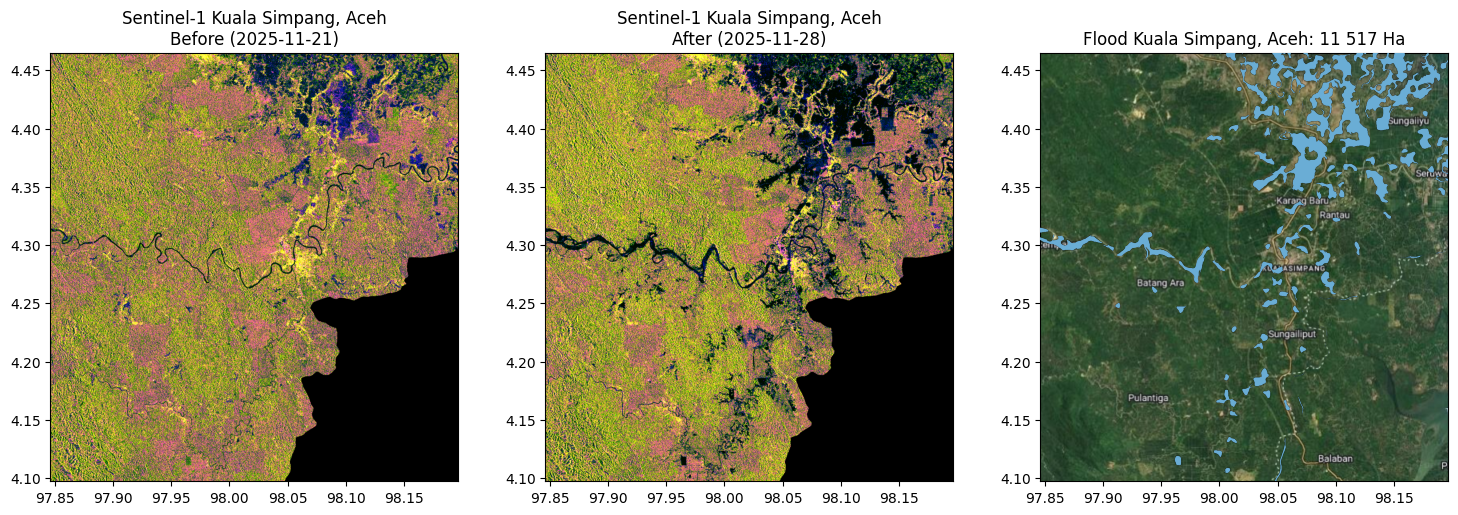

Processing Tanjung Pura


C:\Users\ramiq\AppData\Local\Temp\ipykernel_17744\494762152.py:39: RuntimeWarning: invalid value encountered in divide
  rdi = (vv / 1e4 - vh / 1e4) / (vv / 1e4 + vh / 1e4)
C:\Users\ramiq\AppData\Local\Temp\ipykernel_17744\494762152.py:48: RuntimeWarning: invalid value encountered in cast
  ).astype("uint8")


In [ ]:
# selected_roi
for p in range(len(data_dict)):
    data_info = data_dict[p]
    period_info = data_info["period"]
    provinsi = data_info["provinsi"]
    df_provinsi = df_roi[df_roi["provinsi"] == provinsi]

    for y in range(len(df_provinsi) - 1, len(df_provinsi)):
        roi_select = df_provinsi.iloc[y : y + 1]
        location = roi_select.iloc[0]["name"]
        province = roi_select.iloc[0]["provinsi"]
        print(f"Processing {location}")
        bbox = tuple(roi_select.total_bounds)
        min_x, min_y, max_x, max_y = bbox
        layer_extent = (min_x, max_x, min_y, max_y)
        fig = plt.figure(figsize=(15, 5))

        # define ideal shape
        resolution = 30
        width = int(abs(bbox[0] - bbox[2]) * 111_000 / resolution)
        height = int(abs(bbox[1] - bbox[3]) * 111_000 / resolution)
        shape = (height, width)

        # data dict after clip
        images = dict()

        # load data per period
        for x in range(len(period_info)):
            data_info = period_info[x]
            name = data_info["name"]
            date = data_info["date"]
            path = data_info["s1"]

            # load sentinel-1 image image
            with rio.open(path) as src:
                window = windows.from_bounds(*bbox, transform=src.transform)
                s1 = src.read(window=window, out_shape=shape)
                vv, vh = s1
                rdi = (vv / 1e4 - vh / 1e4) / (vv / 1e4 + vh / 1e4)
                composite_s1 = np.dstack(
                    [
                        rescale_intensity(
                            vv, in_range=(1000, 3000), out_range=(0, 255)
                        ),
                        rescale_intensity(vh, in_range=(0, 1000), out_range=(0, 255)),
                        rescale_intensity(rdi, in_range=(0.5, 1), out_range=(0, 255)),
                    ]
                ).astype("uint8")

                # plot sentinel-1 image
                ax2 = fig.add_subplot(1, 3, x + 1)
                ax2.set_title(f"Sentinel-1 {location}, {province}\n{name} ({date})")
                ax2.imshow(composite_s1, extent=layer_extent)

                # generate water mask
                water = (vv < 1000) * (vh < 500) * 1
                segment = slic(
                    composite_s1 / 255, n_segments=5000, compactness=5, sigma=5
                )
                unique = np.unique(segment)
                water_segment = segment.copy()

                for val in unique:
                    water_segment[segment == val] = mode(
                        water[segment == val], axis=0
                    ).mode

                images[name] = dict(vv=vv, vh=vh, rdi=rdi, water=water_segment)

        # Flood map
        flood_map = (
            (images["Before"]["water"] == 0) * (images["After"]["water"] == 1)
        ).astype("float32")
        flood_area = (np.sum(flood_map) * (resolution**2) / 10_000).astype("uint32")
        flood_map = flood_map.astype("float32")
        flood_map[flood_map == 0] = np.nan

        # Plot flood map
        ax3 = fig.add_subplot(1, 3, 3)
        ax3.set_title(
            f"Flood {location}, {province}: {(f'{flood_area:,}').replace(',', ' ')} Ha"
        )
        ax3.imshow(
            flood_map, extent=layer_extent, cmap="Blues", zorder=9999, vmin=0, vmax=2
        )
        add_basemap(
            ax=ax3,
            crs="EPSG:4326",
            source="http://mt0.google.com/vt/lyrs=y&hl=en&x={x}&y={y}&z={z}",
        )
        fig.tight_layout()

        plt.show(fig)